# Unlearn - KarpathyNet

* **Author** : Yalla Mahanth
* **SR No** : 24004

## imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, Dataset

import os
import tqdm
import math
import json
import copy 
import pickle
import pynvml
import argparse
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime as dt
import matplotlib.gridspec as gridspec

In [2]:
def get_best_gpu(verbose = False):
    pynvml.nvmlInit()
    num_gpus = torch.cuda.device_count()

    if num_gpus == 0:
        if verbose :
            print("[!] No CUDA devices found, running on CPU.")
        return 'cpu'

    gpu_mem = []
    for i in range(num_gpus):
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        free_mem = mem_info.free
        total_mem = mem_info.total
        if verbose:
            print(f"[+] GPU {i}: Total {total_mem / 1e9:.2f} GB, Free {free_mem / 1e9:.2f} GB")
        gpu_mem.append((i, free_mem))

    gpu_mem.sort(key=lambda x: x[1], reverse=True)

    best_gpu = gpu_mem[0][0]
    second_best_gpu = gpu_mem[1][0] if len(gpu_mem) > 1 else best_gpu

    selected_gpu = second_best_gpu if best_gpu == 0 else best_gpu

    pynvml.nvmlShutdown()
    return selected_gpu

def set_gpu(manual_set = None, verbose = False):
    device_active = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device_active == 'cuda':
        if verbose:
            print('[+] CUDA : available')
        try:
            if manual_set is not None:
                GPU_NUMBER = manual_set
            else:
                GPU_NUMBER = get_best_gpu(verbose)
            if verbose:
                print(f'[>] Current Device {torch.cuda.current_device()} -> changing it to {GPU_NUMBER}')
            torch.cuda.set_device(GPU_NUMBER)
            if verbose:
                print(f'[+] Current Device {torch.cuda.current_device()}')
        except Exception as e:
            if verbose:
                print(f'[-] Error Occured while changing GPU ! \n\n\tERROR :{e}\n\n')
                print(f'[!] CUDA ERR : Couldn\'t change  -> using CPU {device_active = }')
        finally: 
            pass
        print(f'[>] device = cuda:{GPU_NUMBER}')
    else :
        if verbose:
            print(f'[!] CUDA ERR : Not available -> using CPU {device_active = }')
        print(f'[>] device = cpu')
set_gpu()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

[>] device = cuda:3


## Cifar10

In [3]:

root_ = './'
cifar_data_folder = f'{root_}data/cifar10/'

cifar_train_batch_1_file = cifar_data_folder + 'data_batch_1'
cifar_train_batch_2_file = cifar_data_folder + 'data_batch_2'
cifar_train_batch_3_file = cifar_data_folder + 'data_batch_3'
cifar_train_batch_4_file = cifar_data_folder + 'data_batch_4'
cifar_train_batch_5_file = cifar_data_folder + 'data_batch_5'
cifar_test_file = cifar_data_folder + 'test_batch' 
cifar_meta_data = cifar_data_folder + 'batches.meta' 

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

cifar_batch_1 = unpickle(cifar_train_batch_1_file) 
cifar_batch_2 = unpickle(cifar_train_batch_2_file)
cifar_batch_3 = unpickle(cifar_train_batch_3_file)
cifar_batch_4 = unpickle(cifar_train_batch_4_file)
cifar_batch_5 = unpickle(cifar_train_batch_5_file)
cifar_batch_test = unpickle(cifar_test_file)
batches_meta = unpickle(cifar_meta_data)

cifar_batch_1_data = cifar_batch_1[b'data']
cifar_batch_1_labels = np.array(cifar_batch_1[b'labels'])
cifar_batch_2_data = cifar_batch_2[b'data']
cifar_batch_2_labels = np.array(cifar_batch_2[b'labels'])
cifar_batch_3_data = cifar_batch_3[b'data']
cifar_batch_3_labels = np.array(cifar_batch_3[b'labels'])
cifar_batch_4_data = cifar_batch_4[b'data']
cifar_batch_4_labels = np.array(cifar_batch_4[b'labels'])
cifar_batch_5_data = cifar_batch_5[b'data']
cifar_batch_5_labels = np.array(cifar_batch_5[b'labels'])

cifar_batch_test_data = cifar_batch_test[b'data']
cifar_batch_test_labels = np.array(cifar_batch_test[b'labels'])

cifar_train_data = np.vstack([cifar_batch_1_data, cifar_batch_2_data, cifar_batch_3_data,cifar_batch_4_data, cifar_batch_5_data]).reshape(-1,32*32*3)
cifar_train_labels = np.hstack([cifar_batch_1_labels, cifar_batch_2_labels, cifar_batch_3_labels,cifar_batch_4_labels, cifar_batch_5_labels])

cifar_test_data = cifar_batch_test_data.reshape(-1,32*32*3)
cifar_test_labels = cifar_batch_test_labels

labels = np.unique(cifar_train_labels)

cifar_label_dict = {}
for i, label in enumerate(labels):
    cifar_label_dict[label] = batches_meta[b'label_names'][i].decode('utf-8')

def train_test_split(X,y,test_size = 0.2 , shuffle = True):
    if shuffle:
        mask = np.random.permutation(len(y))
        X = X[mask]
        y = y[mask]
    split = len(y) - int(len(y) * test_size)
    return X[:split],y[:split],X[split:],y[split:]

Xtr,  ytr, Xval, yval = train_test_split(cifar_train_data, cifar_train_labels, test_size=0.2)
Xte , yte = cifar_test_data, cifar_test_labels
label_dict = cifar_label_dict

print(f'[>] CIFAR-10 Dataset')
print(f'{Xtr.shape = }\t{ytr.shape = }')
print(f'{Xval.shape = }\t{yval.shape = }')
print(f'{Xte.shape = }\t{yte.shape = }')
print(f'{label_dict = }')

Xtr = torch.tensor(Xtr , dtype = torch.float32)
ytr = torch.tensor(ytr , dtype = torch.float32)
Xval = torch.tensor(Xval , dtype = torch.float32)
yval = torch.tensor(yval , dtype = torch.float32)
Xte = torch.tensor(Xte , dtype = torch.float32)
yte = torch.tensor(yte , dtype = torch.float32)

ytr_enc = torch.zeros(ytr.shape[0] , len(labels)) 
yval_enc = torch.zeros(yval.shape[0] , len(labels))
yte_enc = torch.zeros(yte.shape[0] , len(labels))
ytr_enc[torch.arange(ytr.shape[0]) , ytr.long()] = 1
yval_enc[torch.arange(yval.shape[0]) , yval.long()] = 1
yte_enc[torch.arange(yte.shape[0]) , yte.long()] = 1

Xtr = Xtr.view(-1,3,32,32)
Xval = Xval.view(-1,3,32,32)
Xte = Xte.view(-1,3,32,32)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    Xtr = Xtr.cuda()
    Xval = Xval.cuda()
    Xte = Xte.cuda()
    ytr_enc = ytr_enc.cuda()
    yval_enc = yval_enc.cuda()
    yte_enc = yte_enc.cuda()
    ytr = ytr.cuda()
    yval = yval.cuda()
    yte = yte.cuda()    



[>] CIFAR-10 Dataset
Xtr.shape = (40000, 3072)	ytr.shape = (40000,)
Xval.shape = (10000, 3072)	yval.shape = (10000,)
Xte.shape = (10000, 3072)	yte.shape = (10000,)
label_dict = {np.int64(0): 'airplane', np.int64(1): 'automobile', np.int64(2): 'bird', np.int64(3): 'cat', np.int64(4): 'deer', np.int64(5): 'dog', np.int64(6): 'frog', np.int64(7): 'horse', np.int64(8): 'ship', np.int64(9): 'truck'}


## Evaluator

In [4]:
class Evaluator:
    """ Class to handle all the logic concerning the evaluation of trained models.  """
    def __init__(self, device):
        self.device = device

    @staticmethod
    def accuracy(y_true, y_pred):
        """ Computes the accuracy of the predictions, against a reference set of predictions. """
        return sum(yi_true == yi_pred for yi_true, yi_pred in zip(y_true, y_pred)) / len(y_pred)

    
    def evaluate(self, model_path, data, reference_outputs):
        """ Performs the evaluation of a specified model over given data. """
        model = torch.load(os.path.join(model_path, 'model.pt'), map_location=self.device, weights_only=False)
        model.to(self.device)
        model.eval()
        
        generated_outputs = model.predict(data)
        accuracy_score = self.accuracy(reference_outputs, generated_outputs)

        print("[E] EVALUATION:", ">", "accuracy:", f"{accuracy_score:.2%}")
        print()
    
    def evaluate_model(self, model, data, reference_outputs):
        """ Performs the evaluation of a specified model over given data. """
        model.to(self.device)
        model.eval()
        
        generated_outputs = model.predict(data)
        accuracy_score = self.accuracy(reference_outputs, generated_outputs)

        print("[E] EVALUATION:", ">", "accuracy:", f"{accuracy_score:.2%}")
        print()


## KarpathyNet

In [5]:

class KarpathyNet(nn.Module):
    
    def __init__(self, inp_size, filters, filter_sizes, strides, paddings , num_classes, kernal_size = 2, stride = 2):
        super(KarpathyNet,self).__init__() 
        
        self.conv11 = nn.Conv2d(inp_size, filters, kernel_size = filter_sizes, stride = strides, padding = paddings)
        self.conv12 = nn.Conv2d(filters, filters, kernel_size = filter_sizes, stride = strides, padding = paddings)
        self.pool1 = nn.MaxPool2d(kernel_size = kernal_size, stride = stride)
        self.conv21 = nn.Conv2d(filters, filters, kernel_size = filter_sizes, stride = strides, padding = paddings)
        self.conv22 = nn.Conv2d(filters, filters, kernel_size = filter_sizes, stride = strides, padding = paddings)
        self.pool2 = nn.MaxPool2d(kernel_size = kernal_size, stride = stride)
        self.conv31 = nn.Conv2d(filters, filters, kernel_size = filter_sizes, stride = strides, padding = paddings)
        self.conv32 = nn.Conv2d(filters, filters, kernel_size = filter_sizes, stride = strides, padding = paddings)
        self.pool3 = nn.MaxPool2d(kernel_size = kernal_size, stride = stride)
        self.fc_input = 4*4*filters
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self.fc_input, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = self.pool1(x)
        x = F.relu(self.conv21(x))
        x = F.relu(self.conv22(x))
        x = self.pool2(x)
        x = F.relu(self.conv31(x))
        x = F.relu(self.conv32(x))
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x
    
    def predict_proba(self, x):
        x = self.forward(x)
        return F.softmax(x, dim = -1)

    def predict(self, x):
        x = self.predict_proba(x)
        return torch.argmax(x, dim = -1)
    
    def accuracy(self, x, y):
        y_pred = self.predict(x)
        return (y_pred == y).float().mean()
    


net_params = {
    'inp_size': 3,
    'filters': 16,
    'filter_sizes': 5,
    'strides': 1,
    'paddings': 2,
    'num_classes': len(labels)
}
model = KarpathyNet(**net_params)
model

KarpathyNet(
  (conv11): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv12): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv22): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv31): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv32): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=256, out_features=10, bias=True)
)

In [6]:
net_name = 'KarpathyNet'
version_name = 'v1_fine'
directory = f'./models/{net_name}_{version_name}'


if checkpoints := os.listdir(directory):
    last_checkpoint = max(map(lambda x: int(x[11:]), filter(lambda x: 'checkpoint-' in x, checkpoints)))
    checkpoint_dir = os.path.join(directory, f"checkpoint-{last_checkpoint}")
    print(f'[>] loadin {checkpoint_dir}')
    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "model.pt"),map_location=device))
    model.to(device)

[>] loadin ./models/KarpathyNet_v1_fine/checkpoint-156250


<All keys matched successfully>

KarpathyNet(
  (conv11): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv12): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv22): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv31): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv32): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=256, out_features=10, bias=True)
)

In [7]:
evaluator = Evaluator(device)
evaluator.evaluate_model(model,Xte, yte)

[E] EVALUATION: > accuracy: 72.36%



In [8]:
target_class = 7

In [9]:
Xte_wo7 = Xte[yte != target_class]
yte_wo7 = yte[yte != target_class]

## Class Impressoins

In [10]:
target_class = 7

In [11]:
class ImpressionDataset(Dataset):
    def __init__(self, data_tensor):
        self.data = data_tensor
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        return self.data[idx]


### Get impressions


In [12]:
model

KarpathyNet(
  (conv11): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv12): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv21): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv22): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv31): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv32): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
def record_layer_io_shapes(model, input_shape=(1, 3, 32, 32), device='cuda'):
    io_shapes = {}
    hooks = []

    def make_hook(name):
        def hook(module, input, output):
            io_shapes[name] = {
                'input': tuple(input[0].shape),
                'output': tuple(output.shape)
            }
        return hook

    model.eval().to(device)

    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Module):
            hooks.append(module.register_forward_hook(make_hook(name)))

    dummy_input = torch.randn(*input_shape).to(device)
    with torch.no_grad():
        model(dummy_input)

    for h in hooks:
        h.remove()
    return io_shapes

layer_sizes = record_layer_io_shapes(model)
layer_sizes

{'conv11': {'input': (1, 3, 32, 32), 'output': (1, 16, 32, 32)},
 'conv12': {'input': (1, 16, 32, 32), 'output': (1, 16, 32, 32)},
 'pool1': {'input': (1, 16, 32, 32), 'output': (1, 16, 16, 16)},
 'conv21': {'input': (1, 16, 16, 16), 'output': (1, 16, 16, 16)},
 'conv22': {'input': (1, 16, 16, 16), 'output': (1, 16, 16, 16)},
 'pool2': {'input': (1, 16, 16, 16), 'output': (1, 16, 8, 8)},
 'conv31': {'input': (1, 16, 8, 8), 'output': (1, 16, 8, 8)},
 'conv32': {'input': (1, 16, 8, 8), 'output': (1, 16, 8, 8)},
 'pool3': {'input': (1, 16, 8, 8), 'output': (1, 16, 4, 4)},
 'flatten': {'input': (1, 16, 4, 4), 'output': (1, 256)},
 'fc1': {'input': (1, 256), 'output': (1, 10)},
 '': {'input': (1, 3, 32, 32), 'output': (1, 10)}}

In [14]:
def generate_class_impression_from_activation(model, target_class, layer_name, init_mode='kaiming', num_steps=300, lr=0.1, device='cuda', verbose = False):
    model.eval().to(device)

    io_shapes = record_layer_io_shapes(model, device=device)
    if layer_name not in io_shapes:
        raise ValueError(f"Layer '{layer_name}' not found.")

    activation_shape = io_shapes[layer_name]['input']
    if verbose:
        print(f"[+] Shape of activation at input to '{layer_name}': {activation_shape}")

    act_tensor = torch.empty(activation_shape, requires_grad=True, device=device)
    if init_mode == 'kaiming':
        torch.nn.init.kaiming_normal_(act_tensor)
    elif init_mode == 'xavier':
        torch.nn.init.xavier_normal_(act_tensor)
    elif init_mode == 'normal':
        torch.nn.init.normal_(act_tensor, mean=0.0, std=0.02)
    else:
        raise ValueError(f"Unsupported init mode: {init_mode}")

    optimizer = torch.optim.Adam([act_tensor], lr=lr)

    found = False
    tail_layers = []
    for name, module in model.named_modules():
        if name == layer_name:
            found = True
        if found and isinstance(module, torch.nn.Module) and name != '':
            tail_layers.append(module)
    if not tail_layers:
        raise RuntimeError(f"No layers found after {layer_name} to build tail model.")

    tail_net = torch.nn.Sequential(*tail_layers).to(device)


    for step in range(num_steps):
        optimizer.zero_grad()
        output = tail_net(act_tensor)
        target_score = output[0, target_class]
        loss = -target_score
        loss.backward()
        optimizer.step()

        if step % 50 == 0 and verbose:
            print(f"[{step:03d}] Class {target_class} score: {target_score.item():.4f}")

    final_scores = tail_net(act_tensor)
    softmaxes = F.softmax(final_scores, dim=-1)
    max_ele = torch.argmax(softmaxes)
    if verbose :
        print(f'{softmaxes = }\n{max_ele = }')
    
    return act_tensor.detach(), activation_shape , max_ele.item()


# LAYER_NAME = 'pool1'
# TARGET_CLS = 7
# activation, shape, max_ele = generate_class_impression_from_activation( 
#     model, 
#     target_class=TARGET_CLS, 
#     layer_name=LAYER_NAME, 
#     init_mode='kaiming', 
#     num_steps= 1000
# )

In [15]:
layer_names = list(layer_sizes.keys())[:-1]
TARGET_CLS = 7

for layer in layer_names:
    activation, shape, max_ele = generate_class_impression_from_activation( 
        model, 
        target_class=TARGET_CLS, 
        layer_name=layer, 
        init_mode='xavier', 
        num_steps= 1000,
        verbose=False
    )
    print(f'{layer = } {max_ele = }')


layer = 'conv11' max_ele = 0
layer = 'conv12' max_ele = 0
layer = 'pool1' max_ele = 0
layer = 'conv21' max_ele = 0
layer = 'conv22' max_ele = 0
layer = 'pool2' max_ele = 4
layer = 'conv31' max_ele = 4
layer = 'conv32' max_ele = 7
layer = 'pool3' max_ele = 7
layer = 'flatten' max_ele = 7
layer = 'fc1' max_ele = 7


In [16]:
layer_sizes = record_layer_io_shapes(model)
layer_names = list(layer_sizes.keys())[:-1]

In [17]:
target_class = 7
n_attempts = 10
threshold = 8/10
first_responsive_layer = None

all_responses = {}
responsive_layers = []
for layer in layer_names:
    correct = 0
    for _ in range(n_attempts):
        _, _, max_ele = generate_class_impression_from_activation(model, target_class, layer)
        if max_ele == target_class:
            correct += 1
    if correct >= threshold:
        if first_responsive_layer is None:
            first_responsive_layer = layer
        responsive_layers.append(layer)
        
    all_responses[layer] = correct

all_responses, responsive_layers, first_responsive_layer

({'conv11': 0,
  'conv12': 0,
  'pool1': 0,
  'conv21': 0,
  'conv22': 0,
  'pool2': 0,
  'conv31': 0,
  'conv32': 10,
  'pool3': 10,
  'flatten': 10,
  'fc1': 10},
 ['conv32', 'pool3', 'flatten', 'fc1'],
 'conv32')

In [ ]:
def get_learnable_layers(model, responsive_layers):
    learnable_layers = []

    for layer_name in responsive_layers:
        has_params = False
        for name, param in model.named_parameters():
            if layer_name in name and param.requires_grad and param.numel() > 0:
                has_params = True
                break
        if has_params:
            learnable_layers.append(layer_name)
        else:
            print(f"[⏭] Skipping non-learnable layer: {layer_name}")
    
    return learnable_layers

learnable_layers = get_learnable_layers(model, responsive_layers)
learnable_layers

⏭️ Skipping non-learnable layer: pool3
⏭️ Skipping non-learnable layer: flatten


['conv32', 'fc1']

Note : we can choose any responsive layers which is which is common for all the forget examples ( but for sake of experiment and simplicity, let it be last fc layer)

In [19]:
first_responsive_layer = 'fc1'

In [20]:
os.makedirs(f'{directory}/class_impressions/',exist_ok=True)

In [21]:
def generate_class_impression_dataset(model, target_class, layer_name,  num_samples=500, init_mode='kaiming', num_steps=300, lr=0.1, device='cuda'):
    all_activations = []
    eps = 1e-9
    while len(all_activations) < num_samples:
        impression, shape, max_ele = generate_class_impression_from_activation(model, target_class=target_class, layer_name=layer_name, init_mode=init_mode, num_steps=num_steps, lr=lr, device = device)
        if max_ele == target_class:
            for s in all_activations:
                if torch.norm(s - impression) < eps:
                    break
            else:
                all_activations.append(impression)

    stacked_tensor = torch.cat(all_activations, dim=0)
    save_path = f'{directory}/class_impressions/{layer_name}_class_{target_class}_{num_samples}.pt'
    torch.save(stacked_tensor, save_path)
    
    return save_path

In [22]:

TARGET_CLS = 7
NUM_SAMPLES = 100
LAYER_FROM = first_responsive_layer
INIT_MODE = 'xavier'
STEPS_PER_SAMPLE = 1000
LEARN_RATE = 0.1

# path = generate_class_impression_dataset(
#     model=model,
#     target_class= TARGET_CLS,
#     layer_name= LAYER_FROM,
#     num_samples= NUM_SAMPLES,
#     init_mode   = INIT_MODE,
#     num_steps   = STEPS_PER_SAMPLE,
#     lr          = LEARN_RATE,
#     device      = device
# )

# print(f"Saved dataset to {path}")

Saved dataset to ./models/KarpathyNet_v1_fine/class_impressions/fc1_class_7_100.pt


#### genrate Cis

In [23]:
def generate_class_impression(model, target_class, layer_name, directory,  num_samples=500, init_mode='kaiming', num_steps=300, lr=0.1, device='cuda'):
    save_path = f'{directory}/class_impressions/{layer_name}_class_{target_class}_{num_samples}.pt'
    if os.path.exists(save_path):
        print(f"[!] Class impression dataset for class {target_class} and layer {layer_name} already exists.")
        return save_path
    all_activations = []
    eps = 1e-9
    while len(all_activations) < num_samples:
        impression, shape, max_ele = generate_class_impression_from_activation(model, target_class=target_class, layer_name=layer_name, init_mode=init_mode, num_steps=num_steps, lr=lr, device = device)
        if max_ele == target_class:
            for s in all_activations:
                if torch.norm(s - impression) < eps:
                    break
            else:
                all_activations.append(impression)

    stacked_tensor = torch.cat(all_activations, dim=0)
    torch.save(stacked_tensor, save_path)
    
    return save_path

def generate_cis_for_all_classes(labels, model, layer_name, directory, num_samples=500, init_mode='kaiming', num_steps=300, lr=0.1, device='cuda'):
    paths = {}
    for cls in list(labels):    
        paths[cls] = generate_class_impression(
            model=model,
            target_class=cls,
            layer_name=layer_name,
            directory=directory,
            num_samples=num_samples,
            init_mode=init_mode,
            num_steps=num_steps,
            lr=lr,
            device=device 
        )
        print(f'[+] {cls = } {paths[cls] = }')
    return paths 


TARGET_CLS = 7

net_name = 'KarpathyNet'
version_name = 'v1_fine'
directory = f'./models/{net_name}_{version_name}'

NUM_SAMPLES = 100
LAYER_NAME = first_responsive_layer
INIT_MODE = 'xavier'
STEPS_PER_SAMPLE = 1000
LEARN_RATE = 0.1

paths_cis = generate_cis_for_all_classes(
    labels = labels,
    model  = model,
    directory = directory,
    layer_name=LAYER_NAME,
    num_samples=NUM_SAMPLES,
    init_mode=INIT_MODE,
    num_steps=STEPS_PER_SAMPLE,
    lr=LEARN_RATE,
    device=device ,
)
print(paths_cis)

[!] Class impression dataset for class 0 and layer fc1 already exists.
[+] cls = np.int64(0) paths[cls] = './models/KarpathyNet_v1_fine/class_impressions/fc1_class_0_100.pt'
[!] Class impression dataset for class 1 and layer fc1 already exists.
[+] cls = np.int64(1) paths[cls] = './models/KarpathyNet_v1_fine/class_impressions/fc1_class_1_100.pt'
[!] Class impression dataset for class 2 and layer fc1 already exists.
[+] cls = np.int64(2) paths[cls] = './models/KarpathyNet_v1_fine/class_impressions/fc1_class_2_100.pt'
[!] Class impression dataset for class 3 and layer fc1 already exists.
[+] cls = np.int64(3) paths[cls] = './models/KarpathyNet_v1_fine/class_impressions/fc1_class_3_100.pt'
[!] Class impression dataset for class 4 and layer fc1 already exists.
[+] cls = np.int64(4) paths[cls] = './models/KarpathyNet_v1_fine/class_impressions/fc1_class_4_100.pt'
[!] Class impression dataset for class 5 and layer fc1 already exists.
[+] cls = np.int64(5) paths[cls] = './models/KarpathyNet_v1

#### load the cis

In [24]:
def get_class_impression_paths(directory, layer_name, num_samples):
    imp_folder = f'{directory}/class_impressions/'
    paths_ = os.listdir(imp_folder)
    paths = {}
    for p in paths_:
        k = p.split('_')
        cls = int(k[-2])
        num_samp = int(k[-1].split('.')[0])
        layer = k[0]
        if num_samp == num_samples and layer == layer_name:
            paths[cls] = f'{imp_folder}{p}'
    return paths


directory = f'./models/{net_name}_{version_name}'
layer_name = first_responsive_layer
num_samples = NUM_SAMPLES
paths = get_class_impression_paths(directory, layer_name, num_samples)
print(paths)


{0: './models/KarpathyNet_v1_fine/class_impressions/fc1_class_0_100.pt', 1: './models/KarpathyNet_v1_fine/class_impressions/fc1_class_1_100.pt', 2: './models/KarpathyNet_v1_fine/class_impressions/fc1_class_2_100.pt', 3: './models/KarpathyNet_v1_fine/class_impressions/fc1_class_3_100.pt', 4: './models/KarpathyNet_v1_fine/class_impressions/fc1_class_4_100.pt', 5: './models/KarpathyNet_v1_fine/class_impressions/fc1_class_5_100.pt', 6: './models/KarpathyNet_v1_fine/class_impressions/fc1_class_6_100.pt', 7: './models/KarpathyNet_v1_fine/class_impressions/fc1_class_7_100.pt', 8: './models/KarpathyNet_v1_fine/class_impressions/fc1_class_8_100.pt', 9: './models/KarpathyNet_v1_fine/class_impressions/fc1_class_9_100.pt'}


In [25]:

def get_datasets_from_paths(paths, target_class = target_class, labels = labels):
    retain_impressions = []
    retain_y = []
    forget_impressions = []
    forget_y = []
    for i in list(ytr.unique()):
        cls = int(i.item())
        repeated_cls = torch.ones(NUM_SAMPLES , dtype = torch.long) * cls
        if cls == target_class:
            forget_impressions.append(torch.load(paths[cls]))
            forget_y.append(repeated_cls)
        else :
            retain_impressions.append(torch.load(paths[cls]))
            retain_y.append(repeated_cls)
            
    X_forget = torch.cat(forget_impressions)
    X_retain = torch.cat(retain_impressions)
    y_forget = torch.cat(forget_y)
    y_retain = torch.cat(retain_y)

    return X_forget, y_forget, X_retain, y_retain

X_forget, y_forget, X_retain, y_retain = get_datasets_from_paths(paths)
print(f'{X_forget.shape = }\t{y_forget.shape = }')
print(f'{X_retain.shape = }\t{y_retain.shape = }')

X_forget.shape = torch.Size([100, 256])	y_forget.shape = torch.Size([100])
X_retain.shape = torch.Size([900, 256])	y_retain.shape = torch.Size([900])


In [26]:

def get_datasets_from_paths_2(paths, target_classes, labels = labels):
    retain_impressions = []
    retain_y = []
    forget_impressions = []
    forget_y = []
    for i in list(ytr.unique()):
        cls = int(i.item())
        repeated_cls = torch.ones(NUM_SAMPLES , dtype = torch.long , device = device) * cls
        cls_impressions = torch.load(paths[cls]).to(device)
        if cls in target_classes:
            forget_impressions.append(cls_impressions)
            forget_y.append(repeated_cls)
        else :
            retain_impressions.append(cls_impressions)
            retain_y.append(repeated_cls)
            
    X_forget = torch.cat(forget_impressions)
    X_retain = torch.cat(retain_impressions)
    y_forget = torch.cat(forget_y)
    y_retain = torch.cat(retain_y)

    return X_forget, y_forget, X_retain, y_retain

target_classes = {3,4,8}

X_forget, y_forget, X_retain, y_retain = get_datasets_from_paths_2(paths , target_classes)
print(f'{X_forget.shape = }\t{y_forget.shape = }')
print(f'{X_retain.shape = }\t{y_retain.shape = }')

X_forget.shape = torch.Size([300, 256])	y_forget.shape = torch.Size([300])
X_retain.shape = torch.Size([700, 256])	y_retain.shape = torch.Size([700])


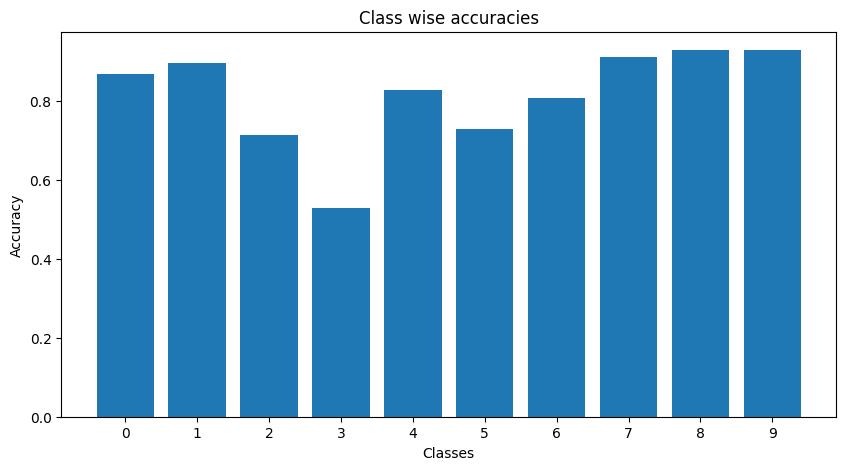

In [33]:
def get_classs_wise_accuracies(model, Xtr, ytr):
    accs = {}
    for i in list(ytr.unique()):
        cls = int(i.item())
        mask = ytr == cls 
        X_cls = Xtr[mask]
        y_cls = ytr[mask]
        acc = model.accuracy(X_cls, y_cls)
        accs[cls] = acc.item()
    return accs

def plot_class_wise_accuracies(accs):
    plt.figure(figsize = (10,5))
    plt.bar(accs.keys(), accs.values())
    plt.xlabel('Classes')
    plt.ylabel('Accuracy')
    plt.title('Class wise accuracies')
    plt.xticks(list(accs.keys()))
    plt.show()
    
    
def plot_compare_class_wise_accuracies(accs1, accs2, text = ''):
    plt.figure(figsize = (10,5))
    plt.bar(np.array(list(accs1.keys())) - 0.2, accs1.values(), width = 0.4, label = 'Original Model')
    plt.bar(np.array(list(accs2.keys())) + 0.2, accs2.values(), width = 0.4, label = 'Unlearned Model')
    plt.xlabel('Classes')
    plt.ylabel('Accuracy')
    plt.title(f'Class wise accuracies {text}')
    plt.legend()
    plt.xticks(list(accs1.keys()))
    plt.show()

plot_class_wise_accuracies(get_classs_wise_accuracies(model, Xtr, ytr))

## unlearn from CI's

In [28]:
def get_tail_from_layer(model,layer_name):
    found = False
    tail_layers = []
    for name, module in model.named_modules():
        if name == layer_name:
            found = True
        if found and isinstance(module, torch.nn.Module) and name != '':
            tail_layers.append(module)
    tail_net = torch.nn.Sequential(*tail_layers)
    return tail_net
first_responsive_layer
get_tail_from_layer(model, first_responsive_layer)

'fc1'

Sequential(
  (0): Linear(in_features=256, out_features=10, bias=True)
)

In [29]:
print(f'{X_forget.shape = } {y_forget.shape} \n{X_retain.shape = } {y_retain.shape}')

X_forget.shape = torch.Size([300, 256]) torch.Size([300]) 
X_retain.shape = torch.Size([700, 256]) torch.Size([700])


## ZeroShotUnlearner - Promissing Results

len(X_forget_dataset) = 300, len(X_retain_dataset) = 700
first_responsive_layer = 'fc1'
✅ Frozen layers before and including: fc1
Epoch [   10/ 1000] | Forget Loss: 1115.696716 | Retain Loss: 2327.841328
Epoch [   20/ 1000] | Forget Loss: 1114.977600 | Retain Loss: 2328.851212
Epoch [   30/ 1000] | Forget Loss: 1114.274254 | Retain Loss: 2329.476517
Epoch [   40/ 1000] | Forget Loss: 1112.864094 | Retain Loss: 2330.979183
Epoch [   50/ 1000] | Forget Loss: 1112.180588 | Retain Loss: 2331.955872
Epoch [   60/ 1000] | Forget Loss: 1111.359600 | Retain Loss: 2332.356499
Epoch [   70/ 1000] | Forget Loss: 1110.287685 | Retain Loss: 2333.718239
Epoch [   80/ 1000] | Forget Loss: 1109.246975 | Retain Loss: 2334.354279
Epoch [   90/ 1000] | Forget Loss: 1108.459702 | Retain Loss: 2335.639931
Epoch [  100/ 1000] | Forget Loss: 1107.317558 | Retain Loss: 2335.719028
Epoch [  110/ 1000] | Forget Loss: 1106.783237 | Retain Loss: 2337.602074
Epoch [  120/ 1000] | Forget Loss: 1105.506592 | Retain 

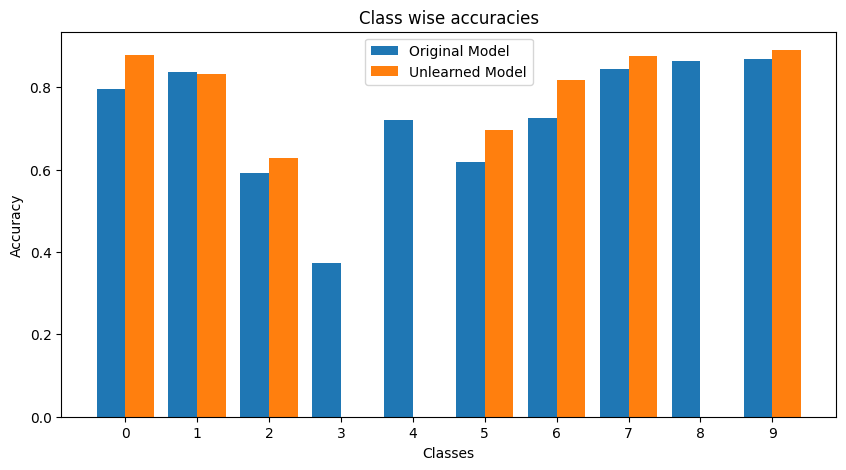

In [ ]:
class ZeroShotUnlearner:
    def __init__(self, model, forget_loader, retain_loader,
                 first_responsive_layer_string,
                 forget_loss_weight=0.9, retain_loss_weight=0.1,
                 lr=1e-4, device='cuda', clip_grad=5.0):
        self.device = device
        self.model = model.to(device)
        self.forget_loader = forget_loader
        self.retain_loader = retain_loader
        self.forget_loss_weight = forget_loss_weight
        self.retain_loss_weight = retain_loss_weight
        self.clip_grad = clip_grad

        self.tail_model = self._get_tail_model(first_responsive_layer_string).to(device)

        self._freeze_before(first_responsive_layer_string)

        self.optimizer = optim.AdamW(self.tail_model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    def _get_tail_model(self, layer_string):
        modules = []
        include = False
        for name, module in self.model.named_children():
            if layer_string in name:
                include = True
            if include:
                modules.append(module)
        if not modules:
            raise ValueError(f"[-] No modules found from '{layer_string}' onward.")
        return nn.Sequential(*modules)

    def _freeze_before(self, layer_string):
        freeze = True
        for name, param in self.model.named_parameters():
            if freeze:
                param.requires_grad = False
            if layer_string in name:
                freeze = False
        print(f"[+] Frozen layers before and including: {layer_string}")

    def unlearn(self, epochs=10):
        self.model.eval()
        self.tail_model.train()

        for ep in range(epochs):
            total_f_loss, total_r_loss = 0.0, 0.0

            for x_f, y_f in self.forget_loader:
                x_f, y_f = x_f.to(self.device), y_f.to(self.device)
                out_f = self.tail_model(x_f)
                loss_f = self.criterion(out_f, y_f)

                loss =  self.forget_loss_weight * loss_f

                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.tail_model.parameters(), self.clip_grad)
                self.optimizer.step()

                total_f_loss += loss_f.item()

            for x_r, y_r in self.retain_loader:
                x_r, y_r = x_r.to(self.device), y_r.to(self.device)
                out_r = self.tail_model(x_r)
                loss_r = self.criterion(out_r, y_r)

                loss = - self.retain_loss_weight * loss_r
                
                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.tail_model.parameters(), self.clip_grad)
                self.optimizer.step()

                total_r_loss += loss_r.item()
            if (ep+1) % 10 == 0:
                print(f"Epoch [{ep+1:5d}/{epochs:5d}] | Forget Loss: {total_f_loss:.6f} | Retain Loss: {total_r_loss:.6f}")

        return self.tail_model



u_model = copy.deepcopy(model)
BATCH_SIZE = 16 

X_forget_dataset = torch.utils.data.TensorDataset(X_forget, y_forget)
X_retain_dataset = torch.utils.data.TensorDataset(X_retain, y_retain)

print(f'{len(X_forget_dataset) = }, {len(X_retain_dataset) = }')
print(f'{first_responsive_layer = }')

unlearner = ZeroShotUnlearner(
    u_model, 
    first_responsive_layer_string= first_responsive_layer,
    forget_loader= torch.utils.data.DataLoader(X_forget_dataset, batch_size=BATCH_SIZE, shuffle=True),
    retain_loader= torch.utils.data.DataLoader(X_retain_dataset, batch_size=BATCH_SIZE, shuffle=True),
    lr = 1e-3,
    forget_loss_weight=0.9, 
    retain_loss_weight=0.1,
)

tail_model = unlearner.unlearn(epochs=1000)

evaluator.evaluate_model(model,Xte, yte)
evaluator.evaluate_model(u_model,Xte, yte)
acc1 = get_classs_wise_accuracies(model, Xte, yte)
acc2 = get_classs_wise_accuracies(u_model, Xte, yte)
plot_compare_class_wise_accuracies(acc1 , acc2)

In [31]:
def split_dataset_forget_retain(X, y, target_classes, labels = labels):
    forget_classes = target_classes
    retain_classes = [yi for yi in labels if yi not in target_classes]
    
    forget_mask = torch.zeros(y.shape[0], dtype=torch.bool).to(device) 
    retain_mask = torch.zeros(y.shape[0], dtype=torch.bool).to(device)
    
    for cls in forget_classes:
        forget_mask |= y == cls
        
    for cls in retain_classes:
        retain_mask |= y == cls
    
    X_forget = X[forget_mask]
    y_forget = y[forget_mask]
    X_retain = X[retain_mask]
    y_retain = y[retain_mask]
    
    return X_forget, y_forget, X_retain, y_retain
    

Xte_forget, yte_forget, Xte_retain, yte_retain = split_dataset_forget_retain(Xte, yte, target_classes)
print(f'{Xte_forget.shape = }\t{yte_forget.shape = }')
print(f'{Xte_retain.shape = }\t{yte_retain.shape = }')
print(f'{target_classes = }')
print(f'\n\nForget classes:')
evaluator.evaluate_model(u_model, Xte_forget, yte_forget)
print(f'Retain classes:')
evaluator.evaluate_model(u_model, Xte_retain, yte_retain)

Xte_forget.shape = torch.Size([3000, 3, 32, 32])	yte_forget.shape = torch.Size([3000])
Xte_retain.shape = torch.Size([7000, 3, 32, 32])	yte_retain.shape = torch.Size([7000])
target_classes = {8, 3, 4}


Forget classes:
[E] EVALUATION: > accuracy: 0.00%

Retain classes:
[E] EVALUATION: > accuracy: 80.23%



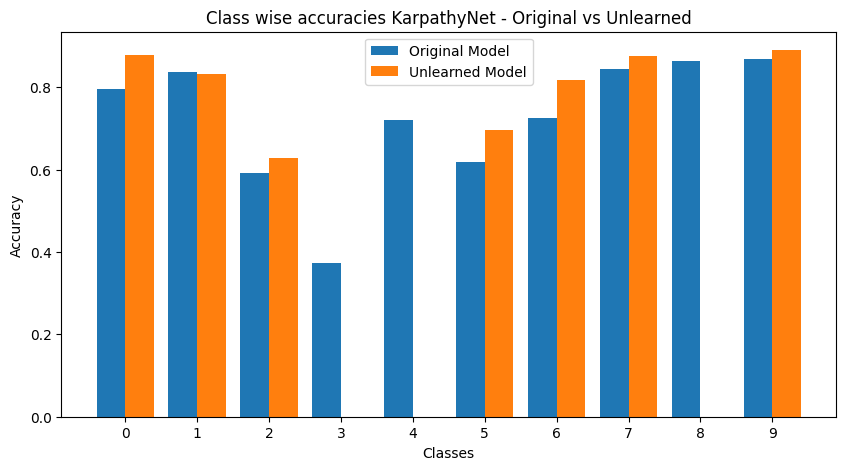

In [34]:
plot_compare_class_wise_accuracies(acc1 , acc2 , 'KarpathyNet - Original vs Unlearned')